In [669]:
import pandas as pd
from itertools import cycle
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt    # we will also use the matplotlib visualisation library
import matplotlib.cm as cm
import warnings
warnings.simplefilter('ignore', category=UserWarning)  # suppresses warning message from Seaborn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# no limit on visible columns 
pd.set_option('display.max_columns', None)

# command below ensures matplotlib output can be included in Notebook
%matplotlib inline

In [670]:
df = pd.read_csv("data/Per 100 Poss.csv") # load dataset into a dataframe
df.sample(5)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg_per_100_poss,fga_per_100_poss,fg_percent,x3p_per_100_poss,x3pa_per_100_poss,x3p_percent,x2p_per_100_poss,x2pa_per_100_poss,x2p_percent,ft_per_100_poss,fta_per_100_poss,ft_percent,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg,d_rtg
337,30795,2023,5069,Kennedy Chandler,NaN,PG,20,1,NBA,MEM,24,0.0,221,5.6,14.1,0.394,0.4,3.0,0.143,5.1,11.1,0.462,1.1,2.4,0.455,1.3,5.1,6.4,9.8,2.1,1.1,3.4,2.8,12.6,96.0,110.0
9329,21999,2009,3843,Othello Hunter,NaN,PF,22,1,NBA,ATL,16,0.0,92,6.4,11.6,0.550,0.0,0.0,NaN,6.4,11.6,0.550,0.0,2.9,0.000,5.2,8.7,14.0,0.6,1.2,2.9,1.2,6.4,12.8,106.0,105.0
24064,7193,1977,1467,Paul McCracken,NaN,SG,26,3,NBA,CHI,9,NaN,119,7.3,19.0,0.383,NaN,NaN,NaN,7.3,19.0,0.383,4.4,7.3,0.611,2.4,4.0,6.5,5.6,2.4,0.0,NaN,6.9,19.0,NaN,98.0
9304,21974,2009,3339,Mike James,1975.0,PG,33,8,NBA,TOT,61,50.0,1649,6.3,16.5,0.383,2.2,5.9,0.375,4.1,10.6,0.388,2.2,2.6,0.829,0.8,3.5,4.3,6.4,1.4,0.2,3.0,3.5,17.0,99.0,117.0
15985,14552,1996,2893,Alvin Heggs,NaN,SF,28,1,NBA,HOU,4,0.0,14,11.0,18.4,0.600,0.0,0.0,NaN,11.0,18.4,0.600,7.4,11.0,0.667,3.7,3.7,7.4,0.0,0.0,0.0,0.0,0.0,29.4,135.0,115.0


In [671]:
df.shape # returns the shape of data - rows and columns

(25412, 36)

In [672]:
# removing players from seasons prior to 2013 - prior to the modern era of basketball
df = df.drop(df[df.season < 2013].index)

# Pre-processing data

## Removing unecessary text from columns

In [673]:
df.columns # list all the different columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg_per_100_poss',
       'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss',
       'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss',
       'x2pa_per_100_poss', 'x2p_percent', 'ft_per_100_poss',
       'fta_per_100_poss', 'ft_percent', 'orb_per_100_poss',
       'drb_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss',
       'stl_per_100_poss', 'blk_per_100_poss', 'tov_per_100_poss',
       'pf_per_100_poss', 'pts_per_100_poss', 'o_rtg', 'd_rtg'],
      dtype='object')

In [674]:
for col in df.columns:
  # replacing percent with % sign
  col_modified = col.replace('_percent', '%')
  # remove _per_100_poss from columns that have it
  if "_per_100_poss" in col:
    col_modified = col.split("_")[0]
    
  df = df.rename(columns = {col:col_modified})

# create copy of original dataframe for later use
df_copy = df.copy()

df.columns


Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p',
       'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

## Size of data and variable types

In [675]:
df.dtypes # returns the datatype of each column

seas_id         int64
season          int64
player_id       int64
player         object
birth_year    float64
pos            object
age             int64
experience      int64
lg             object
tm             object
g               int64
gs            float64
mp              int64
fg            float64
fga           float64
fg%           float64
x3p           float64
x3pa          float64
x3p%          float64
x2p           float64
x2pa          float64
x2p%          float64
ft            float64
fta           float64
ft%           float64
orb           float64
drb           float64
trb           float64
ast           float64
stl           float64
blk           float64
tov           float64
pf            float64
pts           float64
o_rtg         float64
d_rtg         float64
dtype: object

In [676]:
df.shape # returns the shape of data - rows and columns

(7150, 36)

In [677]:
df.index

RangeIndex(start=0, stop=7150, step=1)

## Preliminary exploration of values in the data

In [678]:
df.sample(10) # view random rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
6718,24051,2013,3930,Dexter Pittman,NaN,C,24,3,NBA,TOT,11,0.0,32,6.7,18.5,0.364,0.0,0.0,NaN,6.7,18.5,0.364,0.0,5.0,0.000,11.8,8.4,20.2,0.0,0.0,0.0,5.0,13.4,13.4,75.0,105.0
6226,24743,2014,3389,Jannero Pargo,NaN,PG,34,10,NBA,CHA,29,0.0,242,11.2,25.3,0.441,5.1,12.9,0.400,6.0,12.4,0.483,1.7,2.4,0.727,0.2,4.1,4.3,11.2,3.0,0.2,5.6,3.6,29.2,102.0,103.0
3054,27866,2019,3258,Jamal Crawford,NaN,SG,38,19,NBA,PHO,64,0.0,1211,6.9,17.3,0.397,2.6,8.0,0.332,4.2,9.3,0.453,3.7,4.3,0.845,0.3,3.0,3.4,9.0,1.3,0.5,3.9,3.0,20.0,102.0,119.0
169,30627,2023,3815,Eric Gordon,NaN,SG,34,15,NBA,HOU,47,47.0,1418,7.1,16.3,0.439,2.9,8.3,0.347,4.3,7.9,0.536,3.7,4.6,0.815,0.4,2.9,3.3,4.6,1.0,0.6,2.8,1.5,20.9,112.0,122.0
3237,28049,2019,4657,Melvin Frazier,NaN,SG,22,1,NBA,ORL,10,0.0,44,7.8,23.4,0.333,0.0,6.7,0.000,7.8,16.7,0.467,1.1,4.4,0.250,3.3,2.2,5.6,1.1,1.1,0.0,1.1,6.7,16.7,75.0,113.0
6332,24849,2014,4039,Lavoy Allen,NaN,PF,24,3,NBA,TOT,65,2.0,1072,6.1,13.6,0.447,0.1,0.6,0.154,6.0,13.1,0.460,1.5,2.3,0.660,5.4,8.7,14.1,3.2,1.1,1.5,2.0,5.7,13.8,104.0,108.0
2764,28935,2020,4802,Zach Norvell,NaN,SG,22,1,NBA,TOT,5,0.0,41,3.5,14.0,0.250,3.5,9.3,0.375,0.0,4.7,0.000,1.2,1.2,1.000,0.0,7.0,7.0,3.5,2.3,0.0,3.5,4.7,11.7,74.0,112.0
2675,28846,2020,4207,Solomon Hill,NaN,PF,28,7,NBA,MEM,48,3.0,901,5.0,12.1,0.412,2.9,7.6,0.381,2.1,4.5,0.465,1.3,2.0,0.684,1.2,6.2,7.5,4.9,1.6,0.4,2.1,3.8,14.2,109.0,112.0
103,30561,2023,4484,Damion Lee,NaN,SG,30,6,NBA,PHO,60,5.0,1324,6.4,14.5,0.439,3.6,8.2,0.439,2.7,6.2,0.438,3.2,3.5,0.905,1.0,6.1,7.1,3.4,1.0,0.2,2.6,3.6,19.5,114.0,115.0
2281,28452,2020,4158,Dewayne Dedmon,NaN,C,30,7,NBA,ATL,10,8.0,233,6.6,16.8,0.393,1.6,7.2,0.222,5.0,9.6,0.521,1.4,1.6,0.875,2.8,13.6,16.4,1.4,2.0,3.0,2.0,8.0,16.2,94.0,107.0


In [679]:
df.head() # view first rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
0,30458,2023,5025,A.J. Green,NaN,SG,23,1,NBA,MIL,26,0.0,244,8.3,18.1,0.457,6.5,15.1,0.429,1.8,3.0,0.600,0.8,0.8,1.000,0.8,4.7,5.5,2.4,1.0,0.0,1.4,4.7,23.8,125.0,114.0
1,30459,2023,5026,A.J. Lawson,NaN,SG,22,1,NBA,TOT,13,0.0,63,10.3,20.7,0.500,5.6,12.7,0.438,4.8,7.9,0.600,0.8,2.4,0.333,1.6,6.4,7.9,0.8,0.8,0.0,0.8,6.4,27.0,118.0,118.0
2,30460,2023,5026,A.J. Lawson,NaN,SG,22,1,NBA,MIN,1,0.0,2,23.7,23.7,1.000,0.0,0.0,NaN,23.7,23.7,1.000,0.0,0.0,NaN,0.0,23.7,23.7,0.0,0.0,0.0,0.0,23.7,47.4,200.0,106.0
3,30461,2023,5026,A.J. Lawson,NaN,SG,22,1,NBA,DAL,12,0.0,61,9.9,20.5,0.480,5.8,13.2,0.438,4.1,7.4,0.556,0.8,2.5,0.333,1.6,5.8,7.4,0.8,0.8,0.0,0.8,5.8,26.3,116.0,119.0
4,30462,2023,4219,Aaron Gordon,NaN,PF,27,9,NBA,DEN,49,49.0,1483,10.6,18.0,0.587,1.6,4.1,0.397,9.0,13.9,0.644,5.0,8.0,0.623,3.9,7.2,11.0,4.6,1.3,1.3,2.6,3.0,27.8,127.0,114.0


In [680]:
df.tail() # view last rows

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
7145,24478,2013,3492,Willie Green,NaN,SG,31,10,NBA,LAC,72,60.0,1188,7.9,17.1,0.461,3.1,7.4,0.428,4.7,9.8,0.486,1.0,1.4,0.719,0.8,3.5,4.3,2.4,1.3,0.5,1.4,4.3,19.9,113.0,108.0
7146,24479,2013,3793,Wilson Chandler,NaN,PF,25,6,NBA,DEN,43,8.0,1079,9.8,21.3,0.462,2.4,5.9,0.413,7.4,15.4,0.480,4.1,5.2,0.793,2.1,8.1,10.2,2.7,2.1,0.6,2.8,5.6,26.2,110.0,105.0
7147,24480,2013,3980,Xavier Henry,NaN,SF,21,3,NBA,NOH,50,2.0,625,5.7,14.0,0.410,0.3,1.0,0.364,5.4,13.0,0.413,5.0,8.0,0.630,1.8,6.0,7.8,1.1,1.4,0.4,2.7,6.2,16.8,94.0,111.0
7148,24481,2013,3363,Zach Randolph,NaN,PF,31,12,NBA,MEM,76,75.0,2607,9.8,21.3,0.460,0.0,0.5,0.087,9.8,20.8,0.469,4.7,6.2,0.750,6.5,11.3,17.8,2.2,1.3,0.6,3.1,3.7,24.3,106.0,99.0
7149,24482,2013,3494,Zaza Pachulia,NaN,C,28,10,NBA,ATL,52,15.0,1134,5.2,11.0,0.473,0.0,0.1,0.000,5.2,10.9,0.479,3.6,4.7,0.757,6.0,9.3,15.4,3.6,1.6,0.5,3.2,5.8,14.0,108.0,104.0


In [681]:
df.describe() # view the description of the numerical values in the data set 

,seas_id,season,player_id,birth_year,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
count,7150.000000,7150.000000,7150.000000,53.000000,7150.000000,7150.000000,7150.000000,7150.000000,7150.000000,7149.000000,7149.000000,7099.000000,7149.000000,7149.000000,6491.000000,7149.000000,7149.000000,7037.000000,7149.000000,7149.000000,6709.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7149.000000,7116.000000,7149.000000
mean,27484.500000,2018.191608,4186.560559,1986.981132,26.226713,5.459720,42.595245,19.522657,961.848811,7.153854,16.336341,0.439344,1.852399,5.591481,0.304251,5.301637,10.745321,0.490230,3.027263,4.109036,0.737250,2.281522,6.660330,8.941376,4.230648,1.556553,0.984068,2.702756,4.626549,19.186502,105.446318,109.792978
std,2064.171545,3.135926,424.977956,5.238506,4.157743,4.089226,25.501463,25.499963,797.908434,2.972217,5.303745,0.113652,1.641012,4.086564,0.144262,2.998224,5.113191,0.126909,2.339098,2.952030,0.152881,2.320312,3.324658,4.763022,2.950488,1.168565,1.102453,1.650478,2.569354,7.635843,20.088240,5.236136
min,23910.000000,2013.000000,2863.000000,1975.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000
25%,25697.250000,2015.000000,3891.000000,1983.000000,23.000000,2.000000,20.000000,0.000000,233.250000,5.500000,12.900000,0.396000,0.400000,2.400000,0.260000,3.300000,7.300000,0.442000,1.600000,2.300000,0.667000,0.800000,4.500000,5.600000,2.200000,1.000000,0.300000,1.800000,3.300000,14.800000,99.000000,107.000000
50%,27484.500000,2018.000000,4188.500000,1987.000000,26.000000,4.000000,45.000000,6.000000,787.000000,7.000000,15.900000,0.438000,1.800000,5.700000,0.333000,5.000000,10.400000,0.494000,2.700000,3.700000,0.762000,1.500000,6.100000,7.800000,3.400000,1.400000,0.700000,2.500000,4.200000,18.700000,107.000000,110.000000
75%,29271.750000,2021.000000,4490.000000,1990.000000,29.000000,8.000000,66.000000,34.000000,1571.750000,8.800000,19.500000,0.488000,2.900000,8.200000,0.378000,6.900000,13.700000,0.547000,4.000000,5.500000,0.833000,3.300000,8.400000,11.600000,5.700000,1.900000,1.300000,3.400000,5.500000,23.300000,114.000000,113.000000
max,31059.000000,2023.000000,5100.000000,2002.000000,43.000000,22.000000,83.000000,82.000000,3167.000000,52.600000,53.100000,1.000000,50.100000,50.100000,1.000000,52.600000,53.100000,1.000000,49.700000,51.400000,1.000000,52.600000,49.700000,53.100000,49.000000,25.000000,24.100000,38.400000,99.800000,150.400000,300.000000,127.000000


In [682]:
 # get info about each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7150 entries, 0 to 7149
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   seas_id     7150 non-null   int64  
 1   season      7150 non-null   int64  
 2   player_id   7150 non-null   int64  
 3   player      7150 non-null   object 
 4   birth_year  53 non-null     float64
 5   pos         7150 non-null   object 
 6   age         7150 non-null   int64  
 7   experience  7150 non-null   int64  
 8   lg          7150 non-null   object 
 9   tm          7150 non-null   object 
 10  g           7150 non-null   int64  
 11  gs          7150 non-null   float64
 12  mp          7150 non-null   int64  
 13  fg          7149 non-null   float64
 14  fga         7149 non-null   float64
 15  fg%         7099 non-null   float64
 16  x3p         7149 non-null   float64
 17  x3pa        7149 non-null   float64
 18  x3p%        6491 non-null   float64
 19  x2p         7149 non-null  

## Removing unreliable data

In [683]:
# get the number of missing data points per column
df.isnull().sum()

seas_id          0
season           0
player_id        0
player           0
birth_year    7097
pos              0
age              0
experience       0
lg               0
tm               0
g                0
gs               0
mp               0
fg               1
fga              1
fg%             51
x3p              1
x3pa             1
x3p%           659
x2p              1
x2pa             1
x2p%           113
ft               1
fta              1
ft%            441
orb              1
drb              1
trb              1
ast              1
stl              1
blk              1
tov              1
pf               1
pts              1
o_rtg           34
d_rtg            1
dtype: int64

In [684]:
# remove players that played less than 30 total games, 82 games total per season
df = df.drop(df[df.g < 30].index)

# remove players that played less than 1/4 of possible game time
# each game is 48 min long, 1/4 = 12 min
df = df.drop(df[df.mp < (12*82)].index)

# get the number of missing data points per column
df.isnull().sum()

seas_id          0
season           0
player_id        0
player           0
birth_year    3077
pos              0
age              0
experience       0
lg               0
tm               0
g                0
gs               0
mp               0
fg               0
fga              0
fg%              0
x3p              0
x3pa             0
x3p%           110
x2p              0
x2pa             0
x2p%             0
ft               0
fta              0
ft%              0
orb              0
drb              0
trb              0
ast              0
stl              0
blk              0
tov              0
pf               0
pts              0
o_rtg            0
d_rtg            0
dtype: int64

## Removing irrelevant features

In [685]:
# drop columns that are not player performance stats
df = df.drop(
  ['seas_id', 'birth_year', 'lg','season','player','player_id','experience','tm','age','pos'], axis=1)

# drop columns that do not give information about the role of the player on the court
df = df.drop(
  ['g', 'gs', 'mp'], axis=1)

df.columns


Index(['fg', 'fga', 'fg%', 'x3p', 'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft',
       'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

## Checking for uniqueness of data

In [686]:
# print sum of unique values for each column
for col in df.columns:
  print(f"{col}: {len(df[col].unique())}")

fg: 126
fga: 235
fg%: 333
x3p: 67
x3pa: 161
x3p%: 297
x2p: 134
x2pa: 245
x2p%: 334
ft: 119
fta: 138
ft%: 440
orb: 82
drb: 143
trb: 195
ast: 147
stl: 39
blk: 56
tov: 65
pf: 77
pts: 334
o_rtg: 62
d_rtg: 30


## Filling Null data

In [687]:
# get the number of missing data points per column
df.isnull().sum()

fg         0
fga        0
fg%        0
x3p        0
x3pa       0
x3p%     110
x2p        0
x2pa       0
x2p%       0
ft         0
fta        0
ft%        0
orb        0
drb        0
trb        0
ast        0
stl        0
blk        0
tov        0
pf         0
pts        0
o_rtg      0
d_rtg      0
dtype: int64

### Filling NaN x3p percent

In [688]:
# replacing NaN values for 3 point shots % with 0
df['x3p%'] = df['x3p%'].fillna(0)

# no more missing values
df.isnull().sum()

fg       0
fga      0
fg%      0
x3p      0
x3pa     0
x3p%     0
x2p      0
x2pa     0
x2p%     0
ft       0
fta      0
ft%      0
orb      0
drb      0
trb      0
ast      0
stl      0
blk      0
tov      0
pf       0
pts      0
o_rtg    0
d_rtg    0
dtype: int64

In [689]:
df.sample(10) # view first 10 rows

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
1006,7.9,15.6,0.504,2.0,5.9,0.343,5.9,9.8,0.601,4.4,5.8,0.758,1.7,9.0,10.7,6.2,1.7,0.4,3.1,4.1,22.2,117.0,113.0
3490,5.0,12.7,0.395,3.7,9.7,0.380,1.4,3.1,0.443,1.7,2.0,0.848,1.1,3.9,5.0,1.2,1.7,0.4,1.1,5.4,15.4,116.0,110.0
894,5.8,12.2,0.476,1.2,3.6,0.337,4.6,8.6,0.533,2.9,3.4,0.840,2.1,4.2,6.3,3.5,2.7,1.3,2.1,5.0,15.7,114.0,112.0
6723,10.5,22.4,0.471,2.0,4.8,0.414,8.5,17.5,0.487,5.1,5.9,0.860,1.1,10.0,11.2,4.1,1.2,1.1,2.2,2.9,28.2,111.0,106.0
4505,5.3,10.6,0.505,1.2,3.1,0.391,4.1,7.5,0.552,1.6,2.4,0.678,1.2,3.5,4.8,1.1,2.3,1.0,1.3,3.4,13.5,111.0,109.0
5600,7.6,17.5,0.434,0.4,1.2,0.357,7.1,16.2,0.440,3.7,4.5,0.830,2.9,6.7,9.6,4.1,0.9,1.3,3.1,6.0,19.3,99.0,111.0
4874,11.3,25.4,0.446,0.9,2.6,0.338,10.4,22.8,0.458,10.2,12.0,0.850,1.2,5.3,6.4,5.8,1.5,0.4,3.2,3.1,33.7,113.0,108.0
283,4.7,10.7,0.434,2.2,6.0,0.371,2.4,4.7,0.514,0.9,1.0,0.870,1.9,8.1,10.0,3.0,2.2,0.6,1.2,3.1,12.4,118.0,109.0
6320,9.0,18.2,0.495,0.0,0.0,0.000,9.0,18.2,0.495,2.4,3.7,0.645,6.3,10.2,16.6,1.5,1.3,2.8,2.7,7.2,20.4,106.0,101.0
6620,7.4,16.8,0.441,1.2,3.6,0.333,6.2,13.2,0.471,3.0,3.6,0.816,1.2,3.8,5.0,10.7,1.4,0.1,3.8,3.2,19.0,106.0,111.0


## Scaling data between 0 and 1

In [690]:
# make copy of dataframe
X = df.copy()
column_names = X.columns

# apply MinMaxScaling
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=column_names)

# show newly scaled dataframe
X.describe()

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
count,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000,3090.000000
mean,0.413918,0.427898,0.343212,0.285336,0.332767,0.314129,0.373270,0.385169,0.436837,0.232994,0.225552,0.665312,0.215152,0.318016,0.298202,0.289634,0.325848,0.150391,0.325753,0.346453,0.368883,0.417203,0.495637
std,0.160828,0.164134,0.136505,0.190825,0.206536,0.121910,0.172266,0.174685,0.135279,0.143795,0.135665,0.137387,0.186339,0.178509,0.186292,0.185478,0.146134,0.132453,0.142553,0.129601,0.152590,0.121226,0.157349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.297872,0.305263,0.253275,0.135135,0.181818,0.304000,0.243243,0.258303,0.342048,0.130357,0.125683,0.594828,0.079545,0.181818,0.153846,0.147436,0.230769,0.061538,0.219178,0.252747,0.257212,0.342857,0.379310
50%,0.397163,0.417544,0.315502,0.297297,0.352273,0.348000,0.358108,0.372694,0.422658,0.200000,0.202186,0.688218,0.136364,0.272727,0.239819,0.230769,0.307692,0.107692,0.301370,0.329670,0.350962,0.414286,0.517241
75%,0.517730,0.540351,0.399563,0.418919,0.477273,0.380000,0.486486,0.498155,0.511983,0.305357,0.295082,0.764368,0.303977,0.428571,0.411765,0.397436,0.410256,0.184615,0.410959,0.417582,0.461538,0.485714,0.620690
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [691]:
X.sample(5)

,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
3011,0.468085,0.459649,0.382096,0.000000,0.000000,0.000,0.567568,0.634686,0.379085,0.421429,0.431694,0.610632,0.340909,0.500000,0.475113,0.339744,0.358974,0.184615,0.547945,0.494505,0.418269,0.314286,0.206897
250,0.687943,0.736842,0.318777,0.297297,0.409091,0.300,0.628378,0.660517,0.437908,0.392857,0.355191,0.760057,0.125000,0.214286,0.190045,0.564103,0.230769,0.076923,0.575342,0.263736,0.608173,0.357143,0.758621
2421,0.567376,0.536842,0.412664,0.013514,0.017045,0.176,0.655405,0.704797,0.420479,0.464286,0.437158,0.705460,0.227273,0.525974,0.447964,0.365385,0.282051,0.384615,0.410959,0.340659,0.500000,0.428571,0.172414
1656,0.148936,0.143860,0.347162,0.121622,0.215909,0.245,0.202703,0.162362,0.657952,0.050000,0.098361,0.170977,0.204545,0.285714,0.271493,0.083333,0.410256,0.246154,0.095890,0.362637,0.100962,0.385714,0.379310
782,0.361702,0.270175,0.554585,0.135135,0.164773,0.338,0.398649,0.328413,0.681917,0.085714,0.098361,0.485632,0.352273,0.396104,0.407240,0.192308,0.410256,0.230769,0.219178,0.461538,0.254808,0.542857,0.517241


## Reducing dimensions with PCA

### Choosing number of components

Text(0, 0.5, 'cumulative explained variance')

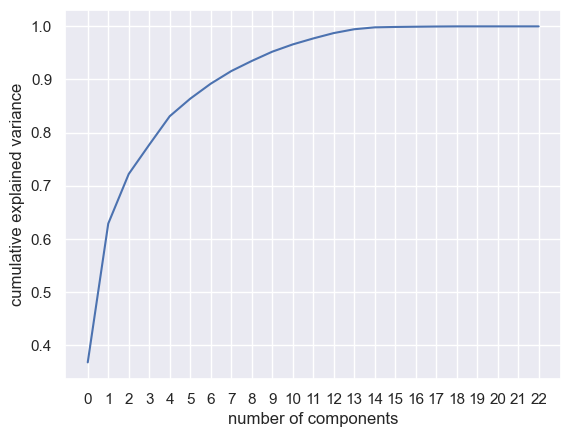

In [692]:
sns.set()

pca = PCA().fit(X)
number_components = range(len(pca.explained_variance_ratio_))

plt.plot(number_components, np.cumsum(pca.explained_variance_ratio_)) #plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(number_components)  
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### Reducing to 13 dimensions

In [693]:
# reduce to 13 dimensions make clustering more effective
X_PCA = PCA(13).fit_transform(X)

# Exploration of data

<Axes: >

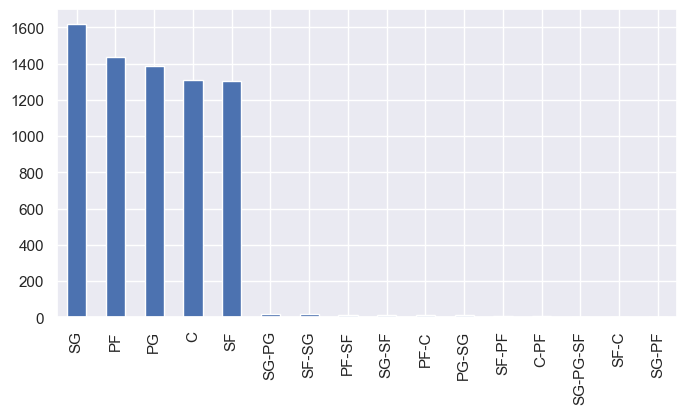

In [727]:
# look at all the different positions listed in the dataset
df_copy['pos'].value_counts().plot.bar(figsize=(8, 4)) 

# Machine learning models

## Kmeans

In [ ]:
def kmeans(X, n_clusters):
    """
        Use KMeans to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Instantiate the model with a particular number of clusters and other parameters
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200,
                   n_init=10, random_state=0)

    # fit the model ... i.e. find the n clusters
    model.fit(X)
    
    # Return key cluster information: score, centres and labels
    
    return (model.inertia_, model.cluster_centers_, model.labels_)

In [ ]:
def gmm(X, n_clusters):
    """
        Use GMM to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Model the data with the specified number of multivariate Gaussians

    model = GaussianMixture(n_components=n_clusters, random_state=123,
                            n_init=10)
    
    # fit the model ... i.e. find n Gaussians that fit the data the best

    model.fit(X)

    # Use BIC score to evaluate fit ... could use aic() instead
    # or model.score(X) which gives score of each data row individually

    score = model.bic(X)
    
    # need to call predict(X) to determine which cluster that each point
    # is most likely to belong to

    labels = model.predict(X)

    return (score, model.means_, labels)
    

# Selecting optimal number of clusters 

In [725]:
# 
kbest_scores = []
gmm_scores = []
kmeans_silhouette_scores = []
gmm_silhouette_scores = []

for i in range(2, 11):
      score, _, labels = kmeans(X_PCA, i)
      sizes = pd.Series(labels).value_counts().to_dict()

      # kmeans inertia score
      print('KMeans has {} clusters with sizes {} with score {:.2f}'
            .format(i, sizes, score))
      kbest_scores.append(score)

      # kmeans silhouette score
      kmeans_silhouette_avg = silhouette_score(X_PCA, labels)
      print("For n_clusters = {}, kmeans silhouette score is {})\n".format(i, kmeans_silhouette_avg))
      kmeans_silhouette_scores.append(kmeans_silhouette_avg)

      # gmm BIC score
      score, _, labels = gmm(X_PCA, i)
      sizes = pd.Series(labels).value_counts().to_dict()

      print('GMM has {} clusters with sizes {} with score {:.2f}'
            .format(i, sizes, score))
      gmm_scores.append(score)
      
      # gmm silhouette score
      gmm_silhouette_avg = silhouette_score(X_PCA, labels)
      print("For n_clusters = {}, gmm silhouette score is {})\n".format(i, gmm_silhouette_avg))
      gmm_silhouette_scores.append(gmm_silhouette_avg)

KMeans has 2 clusters with sizes {0: 2289, 1: 801} with score 1272.69
For n_clusters = 2, kmeans silhouette score is 0.30922474320268667)

GMM has 2 clusters with sizes {0: 2178, 1: 912} with score -46774.92
For n_clusters = 2, gmm silhouette score is 0.27166624737107414)

KMeans has 3 clusters with sizes {1: 1511, 0: 868, 2: 711} with score 1029.09
For n_clusters = 3, kmeans silhouette score is 0.2372019383035923)

GMM has 3 clusters with sizes {1: 1437, 2: 858, 0: 795} with score -47427.74
For n_clusters = 3, gmm silhouette score is 0.18961562586949915)

KMeans has 4 clusters with sizes {0: 938, 3: 808, 2: 673, 1: 671} with score 949.81
For n_clusters = 4, kmeans silhouette score is 0.15702569243818779)

GMM has 4 clusters with sizes {2: 1192, 0: 1010, 1: 599, 3: 289} with score -50620.47
For n_clusters = 4, gmm silhouette score is 0.09772204718975014)

KMeans has 5 clusters with sizes {2: 937, 4: 770, 1: 622, 3: 392, 0: 369} with score 882.80
For n_clusters = 5, kmeans silhouette sc

## Plotting GMM and Kmeans scores

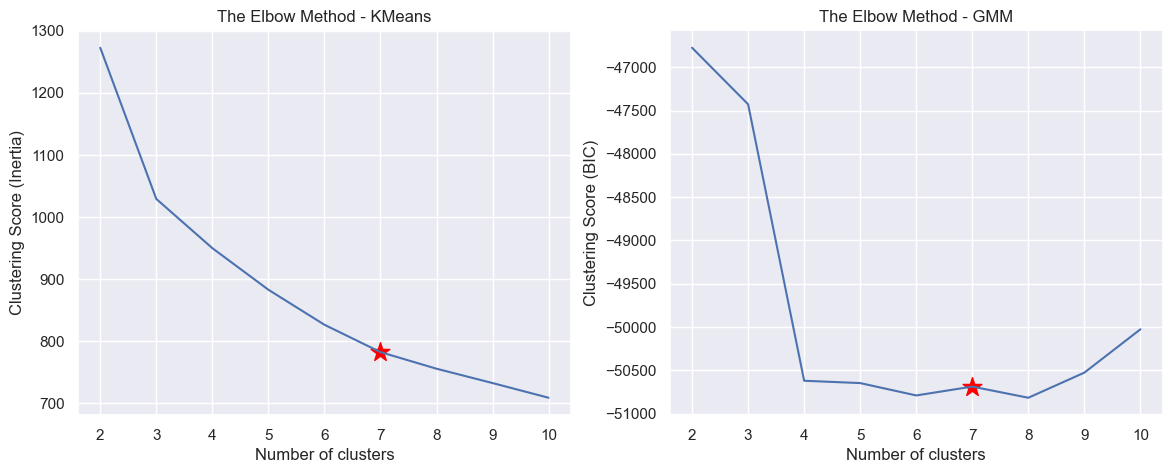

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(2, 11), kbest_scores)
axis[0].set_title('The Elbow Method - KMeans')
axis[0].set_xlabel('Number of clusters')
axis[0].set_ylabel('Clustering Score (Inertia)')
axis[0].scatter(7, kbest_scores[5], s = 200, c = 'red', marker='*')
axis[1].plot(range(2, 11), gmm_scores)
axis[1].scatter(7, gmm_scores[5], s = 200, c = 'red', marker='*')
axis[1].set_title('The Elbow Method - GMM')
axis[1].set_xlabel('Number of clusters')
axis[1].set_ylabel('Clustering Score (BIC)')

plt.show() 

## Plotting Kmeans and GMM silhouette scores

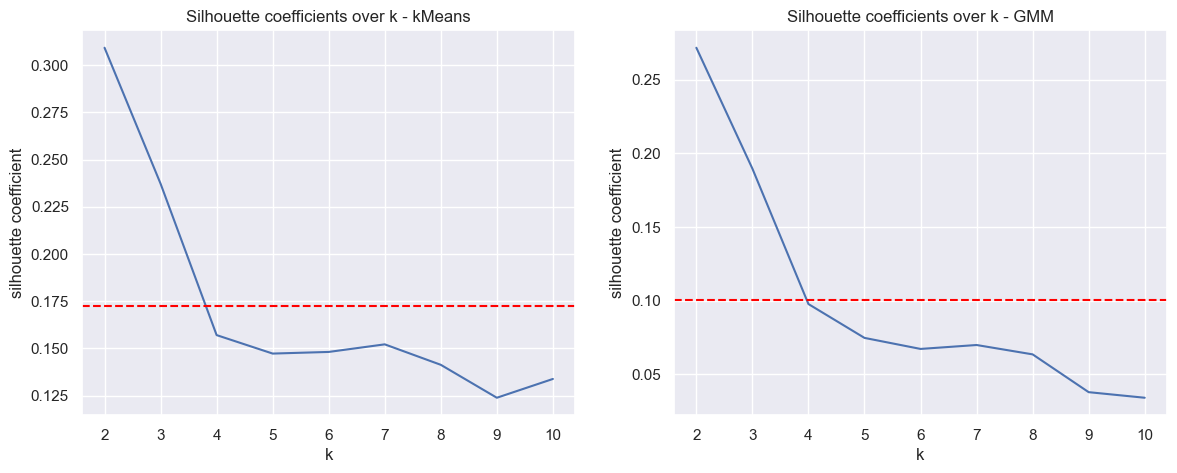

In [724]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(2, 11), kmeans_silhouette_scores)
axis[0].set_title('Silhouette coefficients over k - kMeans')
axis[0].set_xlabel('k')
axis[0].set_ylabel('silhouette coefficient')
axis[0].axhline(y=np.mean(kmeans_silhouette_scores), color="red", linestyle="--")

axis[1].plot(range(2, 11), gmm_silhouette_scores)
axis[1].set_title('Silhouette coefficients over k - GMM')
axis[1].set_xlabel('k')
axis[1].set_ylabel('silhouette coefficient')
axis[1].axhline(y=np.mean(gmm_silhouette_scores), color="red", linestyle="--")

# Listing clusters

In [ ]:
def list_clusters(method, X, n_clusters, scaler, positions):
    
    score, centres, labels = method(X, n_clusters)
    
    sizes = pd.Series(labels).value_counts().to_dict()

    position_split = {}
    for i, label in enumerate(labels):
        position = positions[i]
        if label not in position_split:
            position_split[label] = {}
        if position not in position_split[label]:
            position_split[label][position] = 0
        position_split[label][position] += 1

    # position_split = dict(sorted(position_split.values()))

    print('\nThere are {} clusters with a total score of {:.1f}\n'
          .format(len(sizes), score))

    # Print positions present in each cluster
    for label, _ in enumerate(centres):
        # sort keys of dictionary for easier visibility
        sorted_positions = dict(sorted(position_split[label].items(),))

        print('Cluster {} has {} players with positions {}\n'
                .format(label, sizes[label], sorted_positions))

    return

### Listing Kmeans clusters

In [ ]:
positions = list(df['pos'])
list_clusters(kmeans, X_PCA, 7, scaler, positions)


There are 7 clusters with a total score of 782.3

Cluster 0 has 355 players with positions {'C': 10, 'PF': 33, 'PG': 148, 'PG-SG': 1, 'SF': 69, 'SG': 94}

Cluster 1 has 564 players with positions {'C': 4, 'PF': 56, 'PF-SF': 1, 'PG': 76, 'PG-SG': 1, 'SF': 117, 'SF-PF': 1, 'SF-SG': 6, 'SG': 300, 'SG-PF': 1, 'SG-SF': 1}

Cluster 2 has 463 players with positions {'PF': 8, 'PF-SF': 1, 'PG': 324, 'PG-SG': 2, 'SF': 20, 'SF-SG': 1, 'SG': 100, 'SG-PG': 6, 'SG-SF': 1}

Cluster 3 has 442 players with positions {'C': 74, 'C-PF': 1, 'PF': 220, 'PF-SF': 1, 'PG': 3, 'SF': 102, 'SF-PF': 2, 'SG': 38, 'SG-SF': 1}

Cluster 4 has 251 players with positions {'C': 148, 'PF': 92, 'PF-C': 1, 'PG': 5, 'SF': 3, 'SG': 2}

Cluster 5 has 366 players with positions {'C': 287, 'C-PF': 1, 'PF': 71, 'PG': 1, 'SF': 5, 'SG': 1}

Cluster 6 has 649 players with positions {'C': 15, 'C-PF': 1, 'PF': 127, 'PF-C': 2, 'PF-SF': 3, 'PG': 73, 'SF': 238, 'SF-PF': 1, 'SF-SG': 4, 'SG': 183, 'SG-SF': 2}



### Listing GMM clusters

In [ ]:
list_clusters(gmm, X_PCA, 7, scaler, positions)


There are 7 clusters with a total score of -50688.0

Cluster 0 has 722 players with positions {'C': 1, 'PF': 65, 'PF-SF': 2, 'PG': 41, 'PG-SG': 1, 'SF': 203, 'SF-PF': 1, 'SF-SG': 6, 'SG': 399, 'SG-PF': 1, 'SG-SF': 2}

Cluster 1 has 367 players with positions {'C': 176, 'PF': 153, 'PF-SF': 1, 'PG': 1, 'SF': 27, 'SF-PF': 1, 'SG': 7, 'SG-SF': 1}

Cluster 2 has 623 players with positions {'PF': 3, 'PG': 467, 'PG-SG': 2, 'SF': 10, 'SG': 134, 'SG-PG': 6, 'SG-SF': 1}

Cluster 3 has 569 players with positions {'C': 27, 'C-PF': 2, 'PF': 198, 'PF-C': 2, 'PF-SF': 3, 'PG': 18, 'SF': 214, 'SF-PF': 1, 'SF-SG': 4, 'SG': 99, 'SG-SF': 1}

Cluster 4 has 286 players with positions {'C': 226, 'C-PF': 1, 'PF': 55, 'PG': 1, 'SF': 3}

Cluster 5 has 346 players with positions {'C': 8, 'PF': 81, 'PG': 85, 'PG-SG': 1, 'SF': 95, 'SF-PF': 1, 'SF-SG': 1, 'SG': 74}

Cluster 6 has 177 players with positions {'C': 100, 'PF': 52, 'PF-C': 1, 'PG': 17, 'SF': 2, 'SG': 5}



# Plotting models 

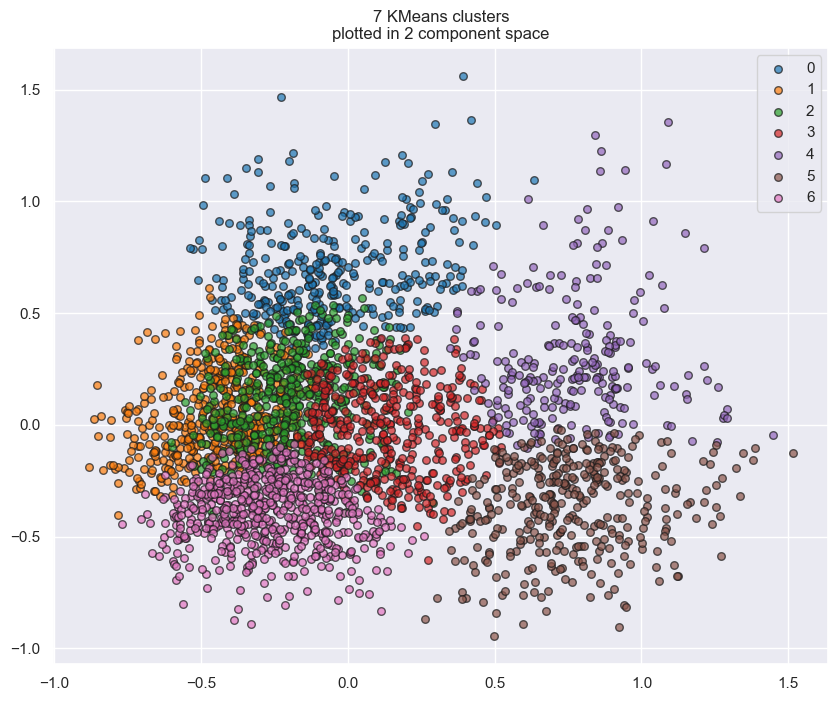

In [ ]:
_, centers, kmeans_labels = kmeans(X_PCA, 7)

# map predictions to label
labels = np.unique(kmeans_labels)
colors = cycle(cm.tab10.colors)
plt.figure(figsize=(10, 8))
plt.title('7 KMeans clusters\nplotted in 2 component space')


for label in labels:
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = kmeans_labels == label
    # plot cluster
    plt.scatter(X_PCA[idx, 0], X_PCA[idx, 1], color=color, s=30, edgecolor='k', label=label, alpha=0.7)
    

plt.legend()

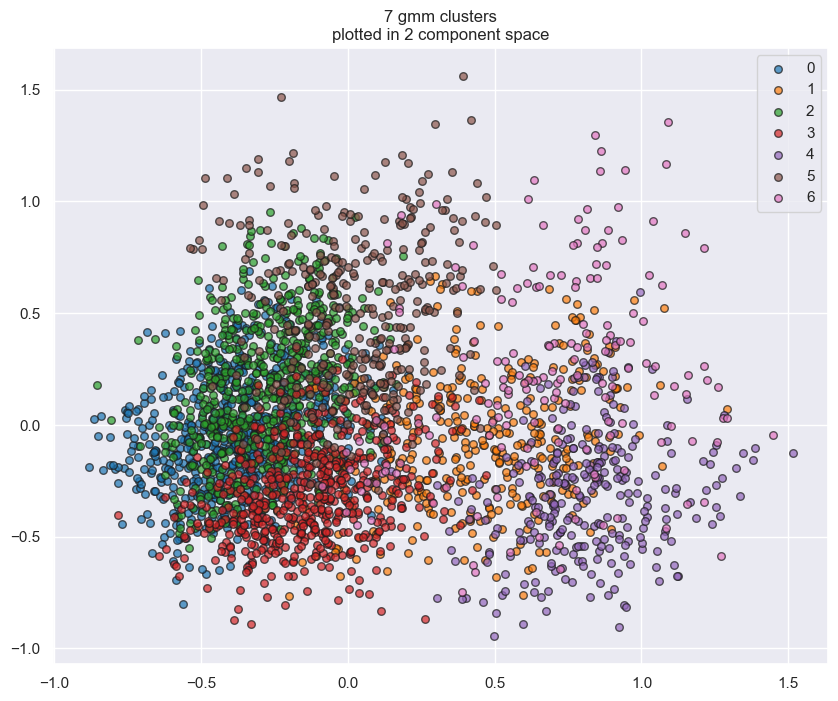

In [ ]:
_, centers, gmm_labels = gmm(X_PCA, 7)

# map predictions to label
labels = np.unique(gmm_labels)
colors = cycle(cm.tab10.colors)
plt.figure(figsize=(10, 8))
plt.title('7 gmm clusters\nplotted in 2 component space')


for label in labels:
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = gmm_labels == label
    # plot cluster
    plt.scatter(X_PCA[idx, 0], X_PCA[idx, 1], color=color, s=30, edgecolor='k', label=label, alpha=0.7)
    

plt.legend()

# Merging cluster predictions into original dataset

In [698]:
_, _, kmeans_labels = kmeans(X_PCA, 7)
_, _, gmm_labels = gmm(X_PCA, 7)

df_cluster = df_copy.copy()

df_cluster['kmeans cluster'] = pd.Series(kmeans_labels, index=df.index)
df_cluster['gmm cluster'] = pd.Series(gmm_labels, index=df.index)

df_cluster.tail(10)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
7140,24473,2013,3978,Wesley Johnson,NaN,SF,25,3,NBA,PHO,50,21.0,953,8.7,21.3,0.407,2.7,8.4,0.323,6.0,13.0,0.461,1.5,1.9,0.771,1.1,5.5,6.6,1.8,1.2,1.0,2.6,3.0,21.5,93.0,110.0,NaN,NaN
7141,24474,2013,3914,Wesley Matthews,NaN,SG,26,4,NBA,POR,69,69.0,2403,7.7,17.7,0.436,3.7,9.3,0.398,4.0,8.4,0.478,3.3,4.1,0.797,0.8,3.4,4.2,3.8,2.0,0.4,2.4,3.8,22.3,111.0,111.0,1.0,6.0
7142,24475,2013,4140,Will Barton,NaN,SG,22,1,NBA,POR,73,5.0,894,6.9,18.2,0.382,0.5,3.8,0.138,6.4,14.3,0.447,2.9,3.8,0.769,2.1,6.4,8.5,3.4,2.0,0.5,3.5,3.3,17.3,87.0,109.0,NaN,NaN
7143,24476,2013,3649,Will Bynum,NaN,PG,30,6,NBA,DET,65,0.0,1219,11.0,23.4,0.469,1.0,3.3,0.316,9.9,20.1,0.494,4.6,5.7,0.809,1.2,3.0,4.2,10.0,2.0,0.2,5.4,5.5,27.6,103.0,111.0,2.0,1.0
7144,24477,2013,3729,Will Conroy,NaN,PG,30,3,NBA,MIN,4,0.0,20,0.0,23.3,0.000,0.0,7.8,0.000,0.0,15.5,0.000,2.6,5.2,0.500,2.6,0.0,2.6,0.0,0.0,0.0,0.0,2.6,2.6,21.0,115.0,NaN,NaN
7145,24478,2013,3492,Willie Green,NaN,SG,31,10,NBA,LAC,72,60.0,1188,7.9,17.1,0.461,3.1,7.4,0.428,4.7,9.8,0.486,1.0,1.4,0.719,0.8,3.5,4.3,2.4,1.3,0.5,1.4,4.3,19.9,113.0,108.0,1.0,6.0
7146,24479,2013,3793,Wilson Chandler,NaN,PF,25,6,NBA,DEN,43,8.0,1079,9.8,21.3,0.462,2.4,5.9,0.413,7.4,15.4,0.480,4.1,5.2,0.793,2.1,8.1,10.2,2.7,2.1,0.6,2.8,5.6,26.2,110.0,105.0,3.0,5.0
7147,24480,2013,3980,Xavier Henry,NaN,SF,21,3,NBA,NOH,50,2.0,625,5.7,14.0,0.410,0.3,1.0,0.364,5.4,13.0,0.413,5.0,8.0,0.630,1.8,6.0,7.8,1.1,1.4,0.4,2.7,6.2,16.8,94.0,111.0,NaN,NaN
7148,24481,2013,3363,Zach Randolph,NaN,PF,31,12,NBA,MEM,76,75.0,2607,9.8,21.3,0.460,0.0,0.5,0.087,9.8,20.8,0.469,4.7,6.2,0.750,6.5,11.3,17.8,2.2,1.3,0.6,3.1,3.7,24.3,106.0,99.0,4.0,0.0
7149,24482,2013,3494,Zaza Pachulia,NaN,C,28,10,NBA,ATL,52,15.0,1134,5.2,11.0,0.473,0.0,0.1,0.000,5.2,10.9,0.479,3.6,4.7,0.757,6.0,9.3,15.4,3.6,1.6,0.5,3.2,5.8,14.0,108.0,104.0,5.0,2.0


In [699]:
df_cluster[df_cluster["player"] == 'Marc Gasol']

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
1864,29391,2021,3835,Marc Gasol,NaN,C,36,13,NBA,LAL,52,42.0,993,4.3,9.5,0.454,2.4,6.0,0.410,1.9,3.5,0.528,1.8,2.4,0.720,1.9,8.7,10.5,5.3,1.3,2.8,2.6,5.6,12.8,115.0,105.0,6.0,5.0
2544,28715,2020,3835,Marc Gasol,NaN,C,35,12,NBA,TOR,44,43.0,1161,4.9,11.4,0.427,2.3,6.1,0.385,2.5,5.4,0.473,1.5,2.0,0.735,1.3,10.0,11.3,6.0,1.4,1.6,2.4,5.1,13.6,110.0,103.0,6.0,5.0
3212,28024,2019,3835,Marc Gasol,NaN,C,34,11,NBA,TOT,79,72.0,2436,7.9,17.6,0.448,2.0,5.5,0.363,5.9,12.1,0.487,3.9,5.1,0.759,1.6,11.1,12.7,7.1,1.7,1.7,3.1,4.4,21.6,108.0,105.0,3.0,4.0
3213,28025,2019,3835,Marc Gasol,NaN,C,34,11,NBA,MEM,53,53.0,1788,8.4,19.0,0.444,2.1,6.1,0.344,6.3,12.8,0.491,4.2,5.6,0.756,1.6,11.1,12.6,6.9,1.7,1.8,3.3,4.1,23.2,106.0,106.0,3.0,4.0
3214,28026,2019,3835,Marc Gasol,NaN,C,34,11,NBA,TOR,26,19.0,648,6.4,13.8,0.465,1.7,3.8,0.442,4.7,10.0,0.474,3.0,3.8,0.769,1.8,10.9,12.7,7.5,1.8,1.7,2.7,5.2,17.5,116.0,104.0,NaN,NaN
3906,27346,2018,3835,Marc Gasol,NaN,C,33,10,NBA,MEM,73,73.0,2408,9.1,21.7,0.420,2.3,6.7,0.341,6.8,15.0,0.456,5.9,7.1,0.834,1.6,10.8,12.4,6.4,1.1,2.1,4.1,3.9,26.4,104.0,108.0,3.0,3.0
4516,26697,2017,3835,Marc Gasol,NaN,C,32,9,NBA,MEM,74,74.0,2531,10.9,23.8,0.459,2.1,5.5,0.388,8.8,18.3,0.480,5.7,6.8,0.837,1.2,8.3,9.5,6.9,1.4,2.0,3.4,3.5,29.7,111.0,106.0,0.0,3.0
5110,26118,2016,3835,Marc Gasol,NaN,C,31,8,NBA,MEM,52,52.0,1791,9.4,20.3,0.464,0.1,0.1,0.667,9.4,20.2,0.463,5.8,7.0,0.829,1.7,8.7,10.4,5.6,1.4,2.0,3.4,4.1,24.7,105.0,106.0,4.0,3.0
5728,25507,2015,3835,Marc Gasol,NaN,C,30,7,NBA,MEM,81,81.0,2687,10.3,20.8,0.494,0.1,0.3,0.176,10.2,20.5,0.500,6.8,8.5,0.795,2.2,10.0,12.2,6.0,1.4,2.5,3.4,4.0,27.4,111.0,100.0,4.0,3.0
6359,24876,2014,3835,Marc Gasol,NaN,C,29,6,NBA,MEM,59,59.0,1970,9.1,19.3,0.473,0.1,0.3,0.182,9.1,19.0,0.477,5.0,6.5,0.768,2.3,9.2,11.5,5.8,1.6,2.1,3.0,4.1,23.3,108.0,102.0,4.0,3.0


In [700]:
df_cluster[df_cluster["kmeans cluster"] == 5].sample(20)

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg,kmeans cluster,gmm cluster
2682,28853,2020,4208,Steven Adams,NaN,C,26,7,NBA,OKC,63,63.0,1680,8.2,13.8,0.592,0.0,0.1,0.333,8.2,13.7,0.594,3.4,5.8,0.582,6.0,10.9,16.9,4.2,1.5,1.9,2.7,3.5,19.8,122.0,106.0,5.0,3.0
4110,27550,2018,3360,Tyson Chandler,NaN,C,35,17,NBA,PHO,46,46.0,1151,5.0,7.8,0.647,0.0,0.0,NaN,5.0,7.8,0.647,2.4,3.9,0.624,5.6,11.8,17.4,2.2,0.7,1.1,2.5,4.4,12.5,123.0,111.0,5.0,2.0
461,30919,2023,4872,Onyeka Okongwu,NaN,C,22,3,NBA,ATL,57,17.0,1365,7.8,12.3,0.631,0.0,0.2,0.200,7.7,12.1,0.637,3.0,4.1,0.741,5.3,9.3,14.6,2.0,1.3,2.6,1.9,6.5,18.6,131.0,112.0,5.0,0.0
6321,24838,2014,3539,Kris Humphries,NaN,PF,28,10,NBA,BOS,69,30.0,1376,8.6,17.2,0.501,0.0,0.1,0.000,8.6,17.2,0.503,4.4,5.4,0.813,4.7,10.5,15.3,2.5,1.2,2.3,2.4,5.1,21.6,113.0,105.0,5.0,2.0
747,29791,2022,4705,Daniel Gafford,NaN,C,23,3,NBA,WAS,72,53.0,1444,9.8,14.1,0.693,0.0,0.0,0.000,9.8,14.0,0.695,3.7,5.2,0.699,5.3,8.6,13.9,2.3,1.0,3.4,2.2,5.8,23.2,134.0,111.0,5.0,2.0
403,30861,2023,4180,Mason Plumlee,NaN,C,32,10,NBA,CHO,56,56.0,1597,7.9,11.8,0.669,0.0,0.0,NaN,7.9,11.8,0.669,4.6,7.6,0.605,5.6,10.5,16.1,6.1,1.0,1.0,2.6,4.8,20.3,133.0,115.0,5.0,2.0
1989,29516,2021,3845,Robin Lopez,NaN,C,32,13,NBA,WAS,71,9.0,1354,9.2,14.5,0.633,0.2,0.6,0.278,9.0,13.9,0.649,3.4,4.7,0.723,4.8,4.5,9.3,1.9,0.5,1.5,2.6,3.7,21.9,124.0,116.0,5.0,0.0
5380,25159,2015,3984,Bismack Biyombo,NaN,C,22,4,NBA,CHO,64,21.0,1243,4.2,7.7,0.543,0.0,0.0,NaN,4.2,7.7,0.543,4.2,7.3,0.583,6.6,10.3,16.9,0.7,0.7,4.1,2.2,5.8,12.6,115.0,99.0,5.0,2.0
948,29992,2022,4634,Jarred Vanderbilt,NaN,PF,22,4,NBA,MIN,74,67.0,1880,5.4,9.1,0.587,0.1,0.4,0.143,5.3,8.8,0.605,2.2,3.3,0.656,5.4,10.3,15.8,2.4,2.5,1.2,1.8,4.6,13.0,127.0,108.0,5.0,0.0
4843,25851,2016,4155,Cody Zeller,NaN,C,23,3,NBA,CHO,73,60.0,1774,6.5,12.4,0.529,0.0,0.3,0.100,6.5,12.1,0.539,4.9,6.6,0.754,3.9,9.0,12.9,2.0,1.6,1.8,1.9,5.8,18.0,119.0,102.0,5.0,0.0


## Creating dataframe with means of columns for each cluster

### Selecting columns to include in means dataframe

In [704]:
df_copy.columns

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p',
       'x3pa', 'x3p%', 'x2p', 'x2pa', 'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'],
      dtype='object')

In [705]:
selected_columns = [
  'age', 'experience', 'g',
  'gs', 'mp', 'fg', 'fga', 'fg%', 'x3p', 'x3pa', 'x3p%', 'x2p', 'x2pa',
  'x2p%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk',
  'tov', 'pf', 'pts', 'o_rtg', 'd_rtg'
]

### Creating new df with means of all columns for kmeans clusters

In [706]:
df_cluster_grouped_kmeans = df_cluster.groupby(['kmeans cluster'])[selected_columns].mean()

df_cluster_grouped_kmeans


,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
kmeans cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,26.847887,7.614085,62.377465,56.366197,2101.287324,11.476056,25.050986,0.458161,3.042817,8.329859,0.357645,8.436338,16.718028,0.505304,6.746197,8.125915,0.829048,1.260845,6.303099,7.567324,7.962535,1.737183,0.634930,4.088451,3.193803,32.736901,112.628169,110.394366
1.0,26.854610,6.310284,64.764184,33.953901,1731.329787,8.208688,19.154610,0.428959,3.731028,9.851064,0.378603,4.476418,9.304078,0.482562,3.043972,3.676418,0.826807,0.939894,4.959574,5.898759,4.016135,1.380674,0.474291,2.268440,3.476418,23.191844,109.969858,112.597518
2.0,26.639309,6.302376,65.725702,36.622030,1763.352052,7.753780,18.016847,0.430853,1.855940,5.417927,0.332389,5.894816,12.600864,0.468451,3.520086,4.444276,0.785099,1.030022,4.870194,5.899568,8.451404,1.880778,0.459611,3.580778,3.697408,20.875810,105.393089,109.814255
3.0,25.592760,5.723982,66.579186,41.201357,1748.377828,8.456561,18.124661,0.468208,1.873756,5.389819,0.342726,6.585520,12.737104,0.520783,3.428507,4.542534,0.753986,2.522851,8.055204,10.578733,3.357240,1.480317,1.226923,2.542534,4.264480,22.216063,109.047511,108.404977
4.0,26.478088,6.852590,67.709163,53.605578,1974.003984,11.105179,21.427888,0.520689,0.502390,1.588446,0.257115,10.603187,19.841036,0.537267,5.366932,7.318725,0.735159,4.204781,10.896813,15.099203,4.244622,1.448207,1.789243,3.511952,4.619522,28.087251,111.665339,105.183267
5.0,26.133880,6.032787,68.551913,40.849727,1590.636612,7.339891,13.045628,0.565904,0.077869,0.317213,0.126140,7.258197,12.722951,0.574251,3.226776,4.987158,0.648161,5.142350,10.046175,15.189344,2.658470,1.329508,2.223224,2.497814,5.453825,17.984699,117.374317,105.956284
6.0,27.092450,5.992296,66.164869,32.493066,1585.807396,5.602003,13.059322,0.430422,2.308012,6.438367,0.354467,3.293991,6.620339,0.500066,1.881818,2.485824,0.756641,1.481048,5.765794,7.243606,3.638521,1.669029,0.785516,1.965794,4.123267,15.396918,108.693374,109.906009


### Creating new df with means of all columns for gmm clusters

In [707]:
df_cluster_grouped_gmm = df_cluster.groupby(['gmm cluster'])[selected_columns].mean()

df_cluster_grouped_gmm


,age,experience,g,gs,mp,fg,fga,fg%,x3p,x3pa,x3p%,x2p,x2pa,x2p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,o_rtg,d_rtg
gmm cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,25.550409,5.574932,65.948229,39.081744,1621.335150,8.762125,17.374114,0.507689,1.050409,3.150681,0.296429,7.708174,14.223706,0.546341,3.674659,4.944959,0.743204,3.734605,9.138692,12.876294,2.833787,1.298638,1.782016,2.539237,4.912807,22.251499,112.787466,108.059946
1.0,26.895666,6.465490,64.918138,38.361156,1773.808989,8.061637,18.676083,0.429971,2.446067,6.820064,0.351859,5.613804,11.857143,0.471507,3.588283,4.423274,0.802560,0.945104,4.616051,5.559069,8.445425,1.853612,0.410273,3.502408,3.651364,22.153291,107.675762,110.311396
2.0,26.356643,6.321678,69.066434,44.185315,1664.835664,7.713986,14.042657,0.556304,0.000000,0.039860,0.000000,7.713986,13.994755,0.558115,3.415385,5.289860,0.645150,5.195804,10.324825,15.522028,2.605245,1.294755,2.205944,2.655594,5.313287,18.843007,114.891608,105.202797
3.0,27.056497,7.395480,67.915254,51.485876,1939.757062,10.166102,19.399435,0.528102,0.615254,1.924294,0.307113,9.549718,17.483051,0.550610,5.291525,7.335593,0.715531,3.743503,10.535593,14.271751,5.619774,1.613559,1.941808,3.624859,4.618079,26.248023,113.836158,104.768362
4.0,26.679191,7.384393,63.572254,55.517341,2084.439306,10.611272,23.236127,0.455647,2.626301,7.345087,0.346477,7.989884,15.891329,0.502416,6.354624,7.758382,0.813448,1.550867,7.176879,8.730925,6.846243,1.733237,0.767341,3.747110,3.249422,30.204046,111.482659,109.670520
5.0,26.724077,5.982425,66.177504,34.072056,1614.636204,6.382601,14.461511,0.442596,2.307381,6.495431,0.351506,4.076450,7.964323,0.513496,2.136907,2.898418,0.737501,1.981019,6.872056,8.850264,3.373462,1.737434,0.955009,2.118981,4.310193,17.207557,109.124780,109.065026
6.0,26.620499,6.062327,65.767313,34.948753,1743.686981,7.748061,17.933657,0.432007,3.164266,8.452493,0.372175,4.582548,9.481302,0.485942,2.900554,3.578809,0.810529,0.964820,4.935319,5.900139,3.544183,1.354848,0.453601,2.170083,3.505956,21.561219,108.563712,112.113573


# Visualisation of data

In [723]:
# get cluster numbers
clusters = df_cluster_grouped_kmeans.index
# load colors for each cluster
cluster_colors = cm.tab10.colors

# Usage

## Games started

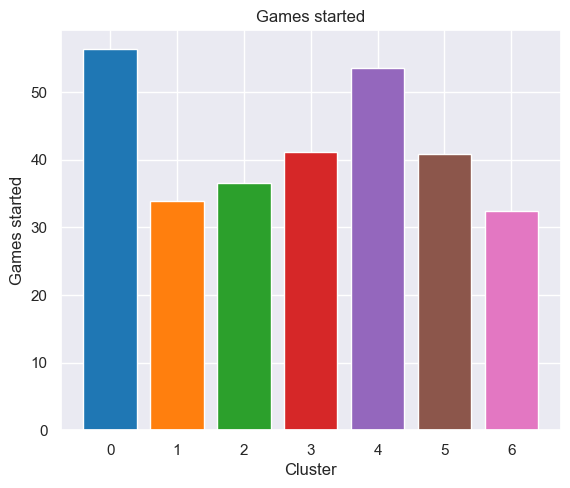

In [709]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting games started for each cluster
gs = df_cluster_grouped_kmeans['gs']

ax.bar(clusters,gs, color=cluster_colors)
ax.set_title('Games started')
ax.set_xlabel('Cluster')
ax.set_ylabel('Games started')
plt.show()

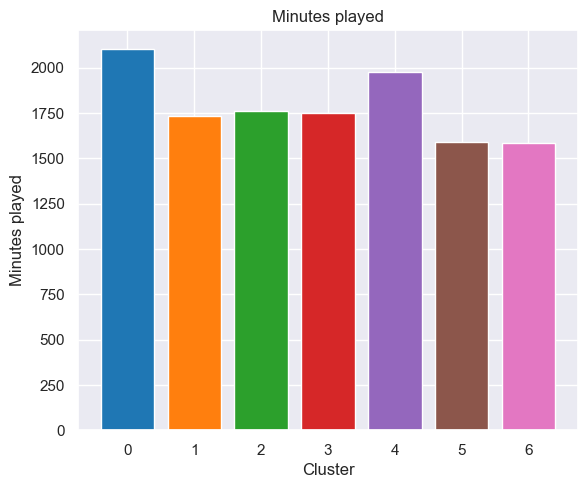

In [710]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting minutes played for each cluster
mp = df_cluster_grouped_kmeans['mp']

ax.bar(clusters,mp, color=cluster_colors)
ax.set_title('Minutes played')
ax.set_xlabel('Cluster')
ax.set_ylabel('Minutes played')
plt.show()

# Offensive stats

## Points scored

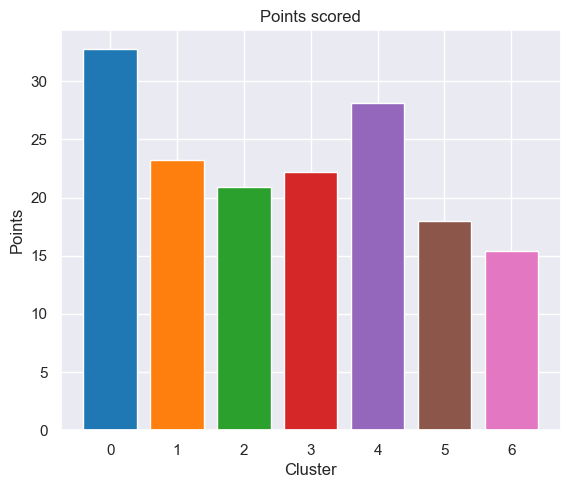

In [711]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting points for each cluster
points = df_cluster_grouped_kmeans['pts']

ax.bar(clusters,points, color=cluster_colors)
ax.set_title('Points scored')
ax.set_xlabel('Cluster')
ax.set_ylabel('Points')
plt.show()

## Assists

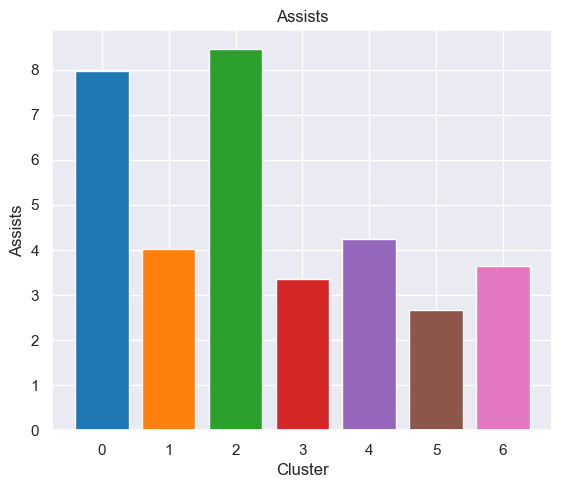

In [712]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting assists for each cluster
assists = df_cluster_grouped_kmeans['ast']

ax.bar(clusters,assists, color=cluster_colors)
ax.set_title('Assists')
ax.set_xlabel('Cluster')
ax.set_ylabel('Assists')
plt.show()

# Rebounds

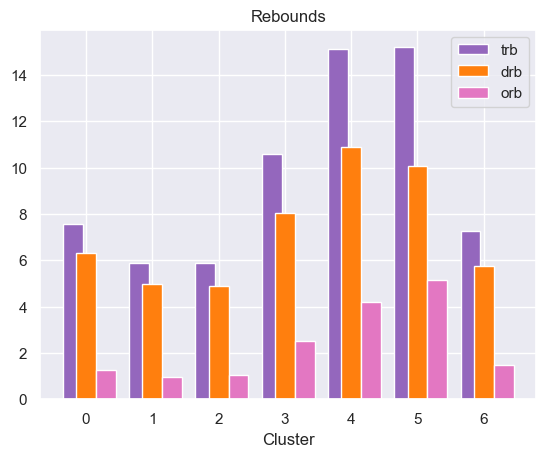

In [713]:
# get all the different rebound stats for each cluster
total_rebounds = df_cluster_grouped_kmeans['trb']
defensive_rebounds = df_cluster_grouped_kmeans['drb']
offensive_rebounds = df_cluster_grouped_kmeans['orb']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, total_rebounds, width=w, color=cluster_colors[4], align='center')
ax.bar(x, defensive_rebounds, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, offensive_rebounds, width=w, color=cluster_colors[6], align='center')
ax.legend(('trb', 'drb','orb') )
ax.set_xlabel('Cluster')
ax.set_title('Rebounds')

plt.show()


# Shooting

## Shooting attempts

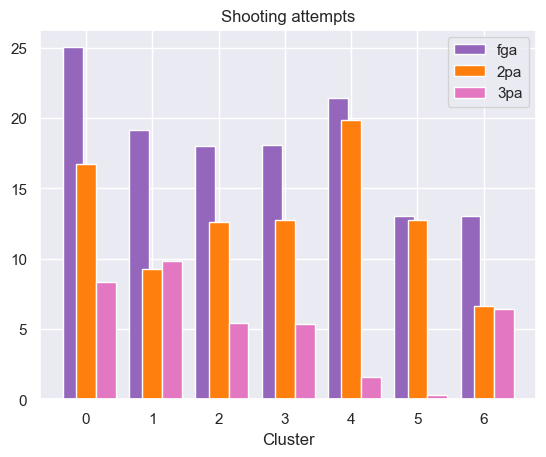

In [714]:
# getting shooting attemps for each cluster
fg_percent = df_cluster_grouped_kmeans['fga']
two_point_attempts = df_cluster_grouped_kmeans['x2pa']
three_point_attempts = df_cluster_grouped_kmeans['x3pa']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, fg_percent, width=w, color=cluster_colors[4], align='center')
ax.bar(x, two_point_attempts, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, three_point_attempts, width=w, color=cluster_colors[6], align='center')
ax.legend(('fga', '2pa','3pa') )
ax.set_xlabel('Cluster')
ax.set_title('Shooting attempts')

plt.show()


## Shooting accuracy

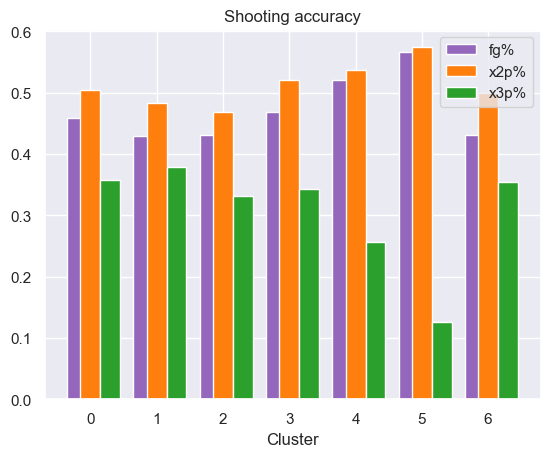

In [715]:
# getting shooting accuracy columns for each cluster
fg_percent = df_cluster_grouped_kmeans['fg%']
x2p_percent = df_cluster_grouped_kmeans['x2p%']
x3p_percent = df_cluster_grouped_kmeans['x3p%']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, fg_percent, width=w, color=cluster_colors[4], align='center')
ax.bar(x, x2p_percent, width=w, color=cluster_colors[1], align='center')
ax.bar(x+w, x3p_percent, width=w, color=cluster_colors[2], align='center')
ax.legend(('fg%', 'x2p%','x3p%') )
ax.set_xlabel('Cluster')
ax.set_title('Shooting accuracy')

plt.show()


## Turnovers

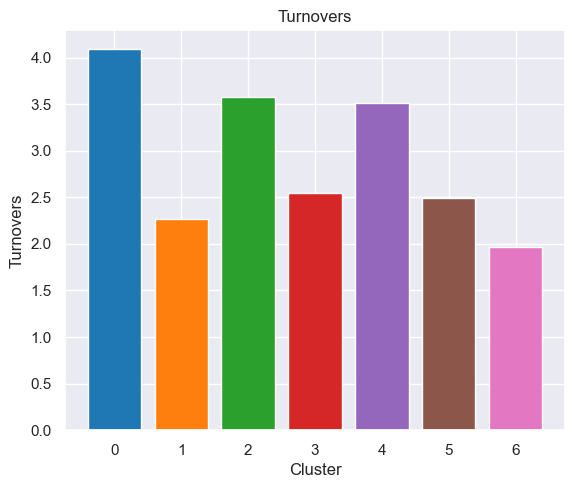

In [716]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting turnovers for each cluster
turnovers = df_cluster_grouped_kmeans['tov']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Turnovers')
ax.set_xlabel('Cluster')
ax.set_ylabel('Turnovers')
plt.show()

# Free throws

## Free throw attempts

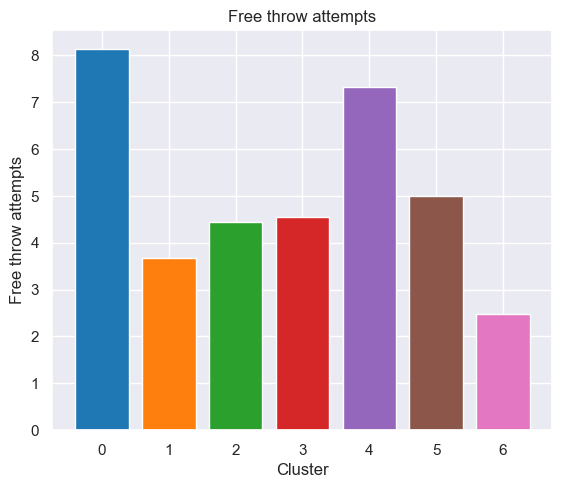

In [717]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting free throw attempts for each cluster
turnovers = df_cluster_grouped_kmeans['fta']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Free throw attempts')
ax.set_xlabel('Cluster')
ax.set_ylabel('Free throw attempts')
plt.show()

## Free throw accuracy

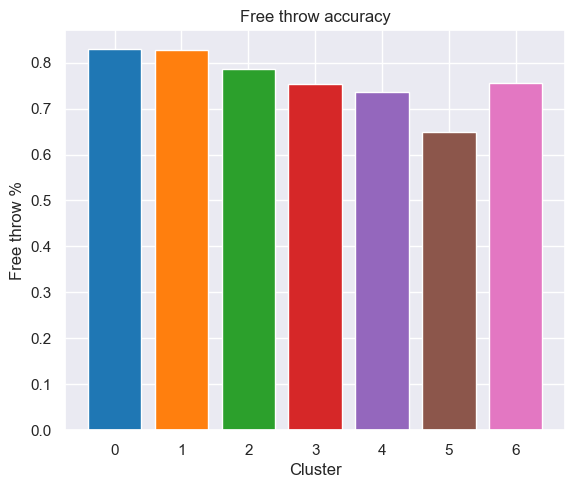

In [718]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting free throw % for each cluster
turnovers = df_cluster_grouped_kmeans['ft%']

ax.bar(clusters,turnovers, color=cluster_colors)
ax.set_title('Free throw accuracy')
ax.set_xlabel('Cluster')
ax.set_ylabel('Free throw %')
plt.show()

# Defensive contributions

## Blocks and steals

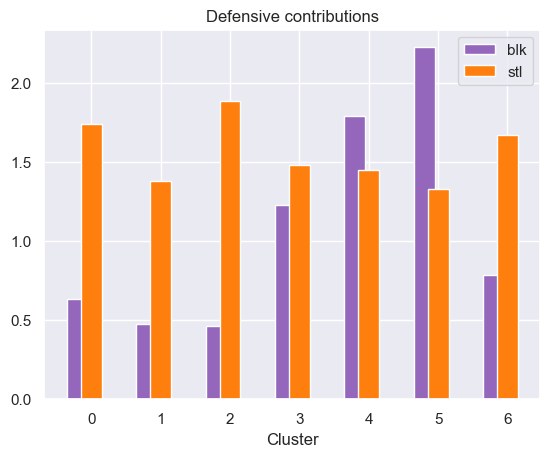

In [719]:
# getting blocks and steals for each cluster
blocks = df_cluster_grouped_kmeans['blk']
steals = df_cluster_grouped_kmeans['stl']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, blocks, width=w, color=cluster_colors[4], align='center')
ax.bar(x, steals, width=w, color=cluster_colors[1], align='center')
ax.legend(('blk','stl','pf') )
ax.set_xlabel('Cluster')
ax.set_title('Defensive contributions')

plt.show()


## Personal fouls

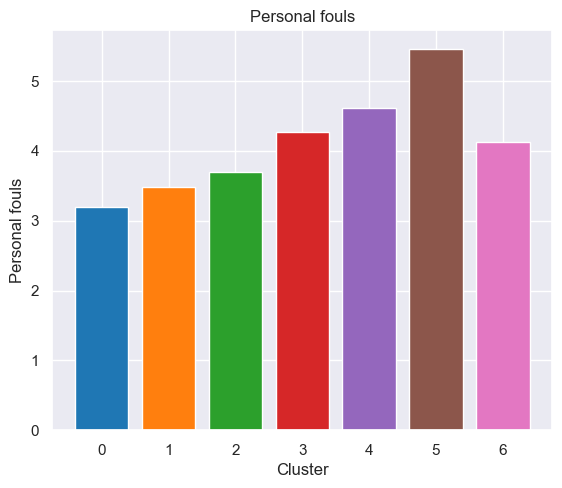

In [720]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([1,1,1,1])

# getting personal fouls for each cluster
personal_fouls = df_cluster_grouped_kmeans['pf']

ax.bar(clusters,personal_fouls, color=cluster_colors)
ax.set_title('Personal fouls')
ax.set_xlabel('Cluster')
ax.set_ylabel('Personal fouls')
plt.show()

# Defensive and Offensive ratings

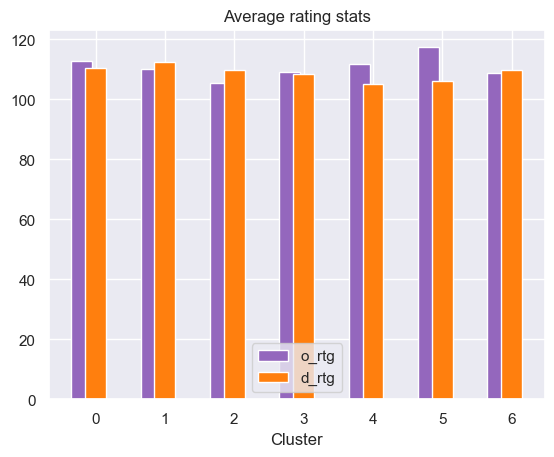

In [721]:
# getting offensive and defensive ratings for each cluset
o_rtg = df_cluster_grouped_kmeans['o_rtg']
d_rtg = df_cluster_grouped_kmeans['d_rtg']

ax = plt.subplot(111)
x=clusters 
w = 0.3
ax.bar(x-0.2, o_rtg, width=w, color=cluster_colors[4], align='center')
ax.bar(x, d_rtg, width=w, color=cluster_colors[1], align='center')
ax.legend(('o_rtg', 'd_rtg') )
ax.set_xlabel('Cluster')
ax.set_title('Average rating stats')

plt.show()


For n_clusters = 2 The average silhouette_score is : 0.3090506144527597
For n_clusters = 3 The average silhouette_score is : 0.23814650525105455
For n_clusters = 4 The average silhouette_score is : 0.20557029045581163
For n_clusters = 5 The average silhouette_score is : 0.14674054059734717
For n_clusters = 6 The average silhouette_score is : 0.14818266693570198
For n_clusters = 7 The average silhouette_score is : 0.13766727154578468
For n_clusters = 8 The average silhouette_score is : 0.14376190806361022
For n_clusters = 9 The average silhouette_score is : 0.13843004460303682


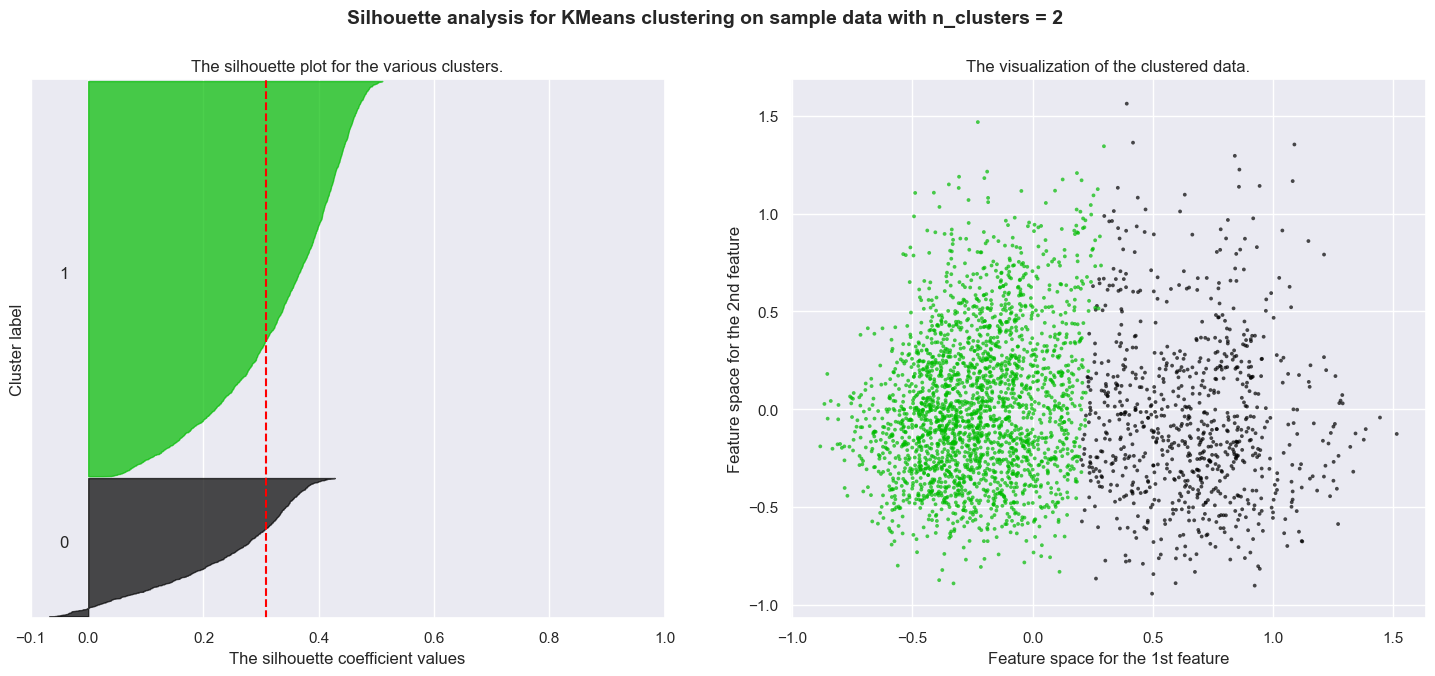

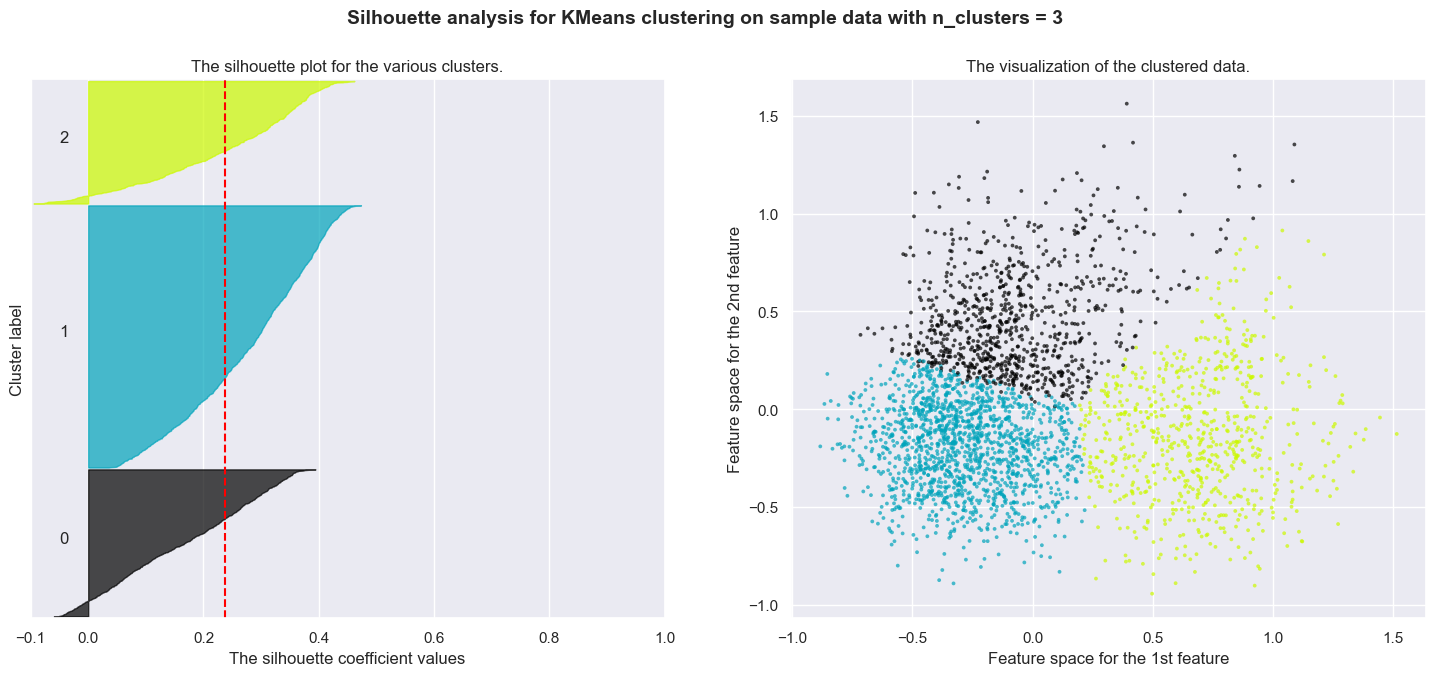

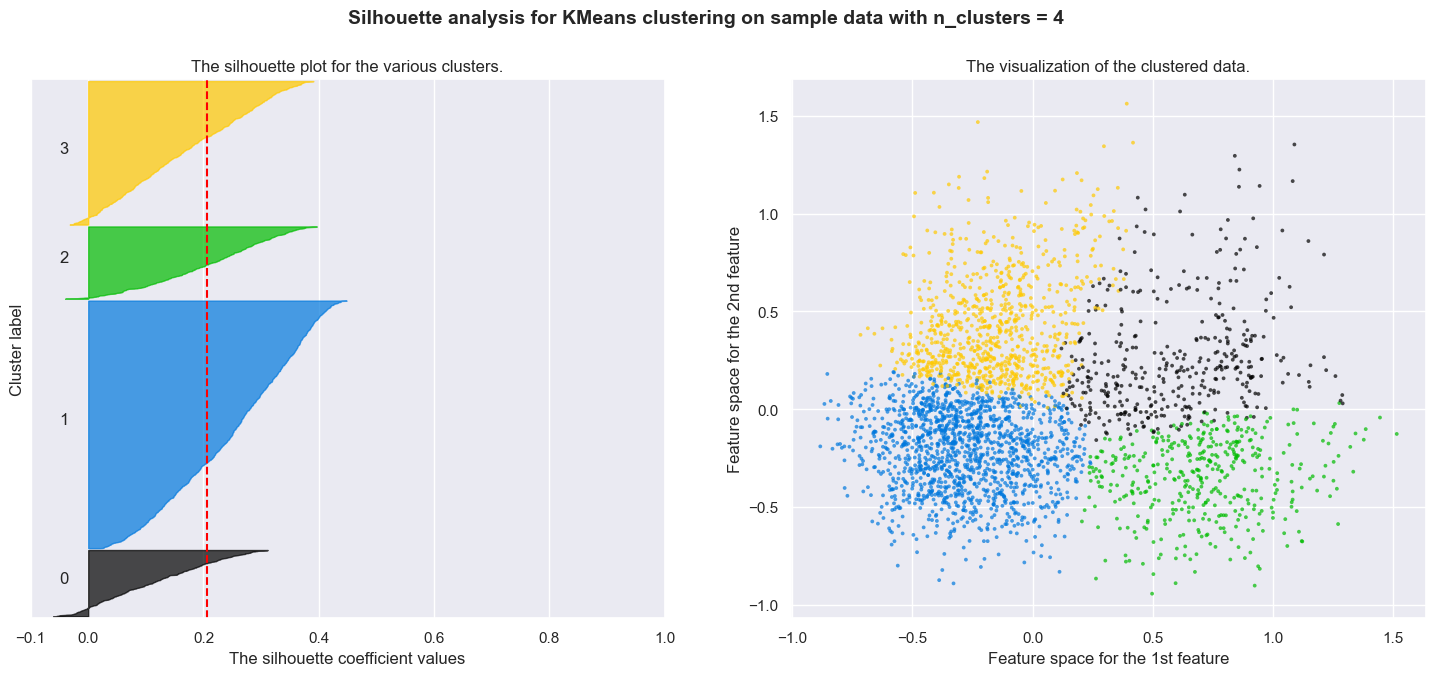

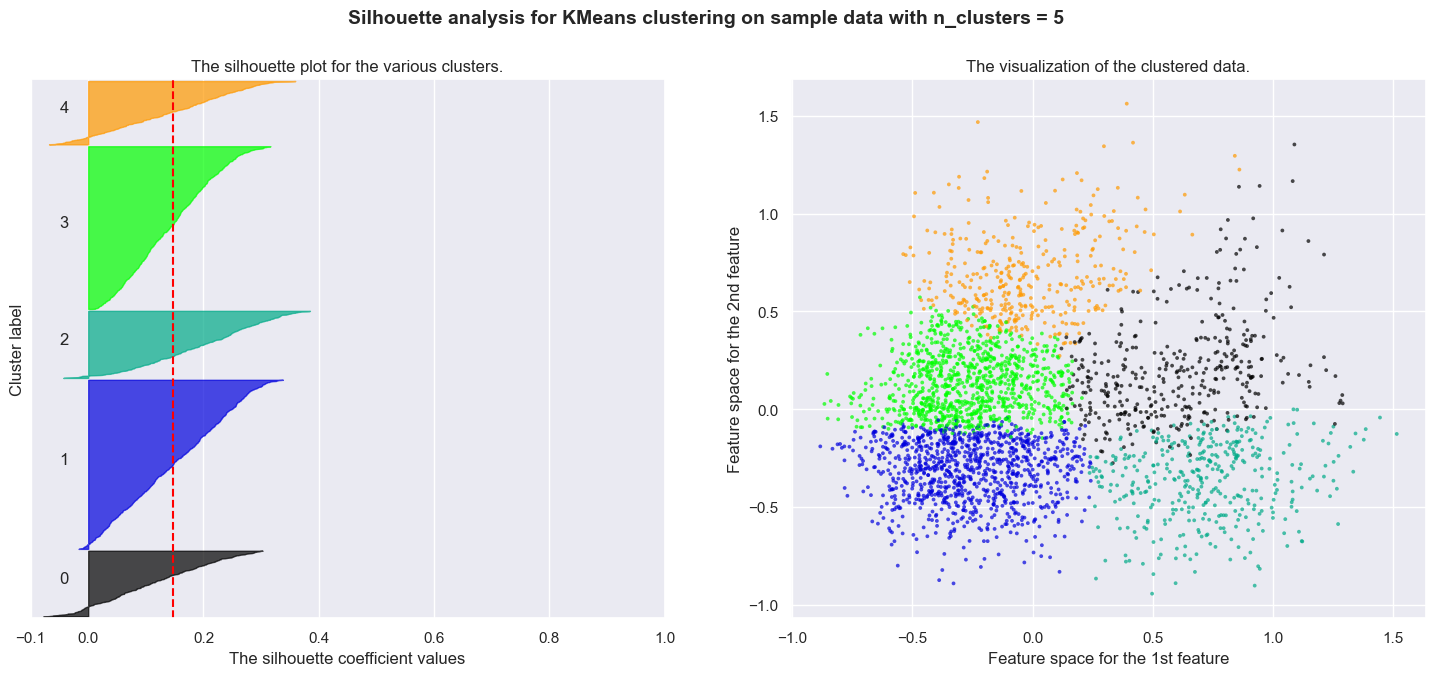

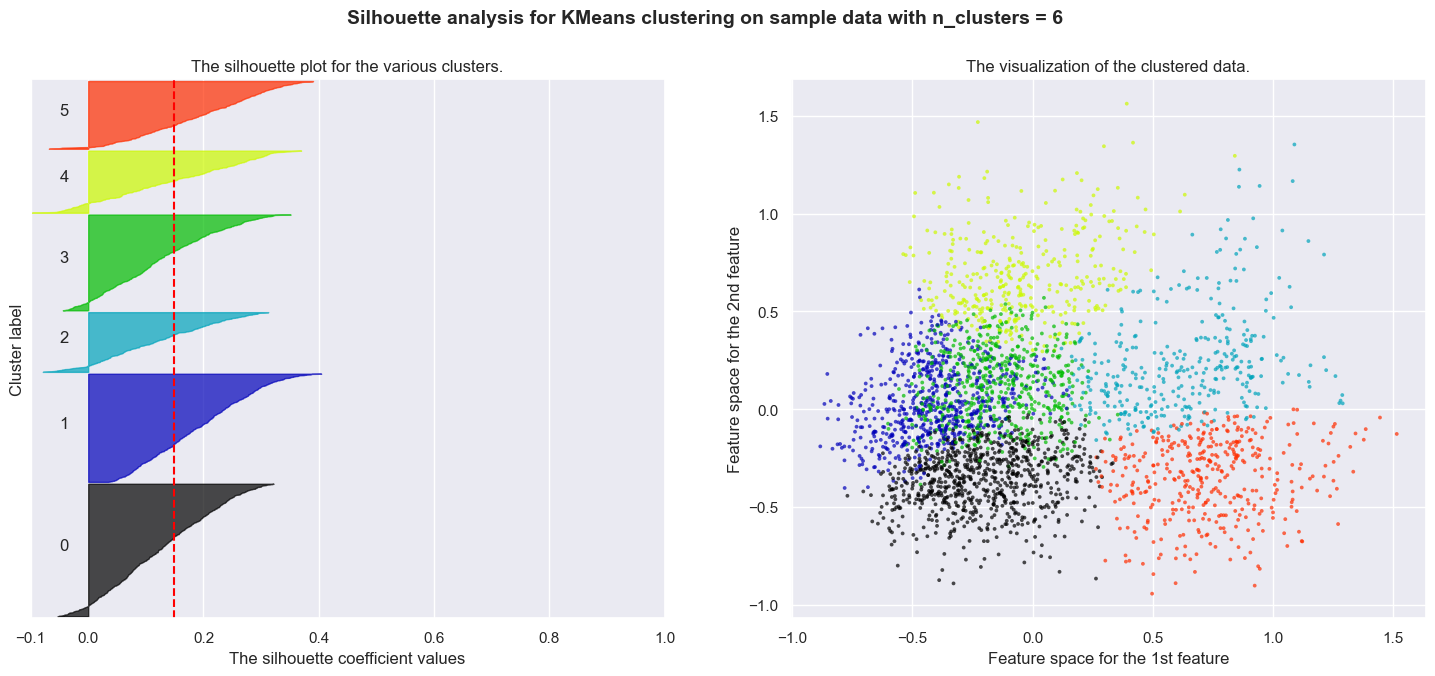

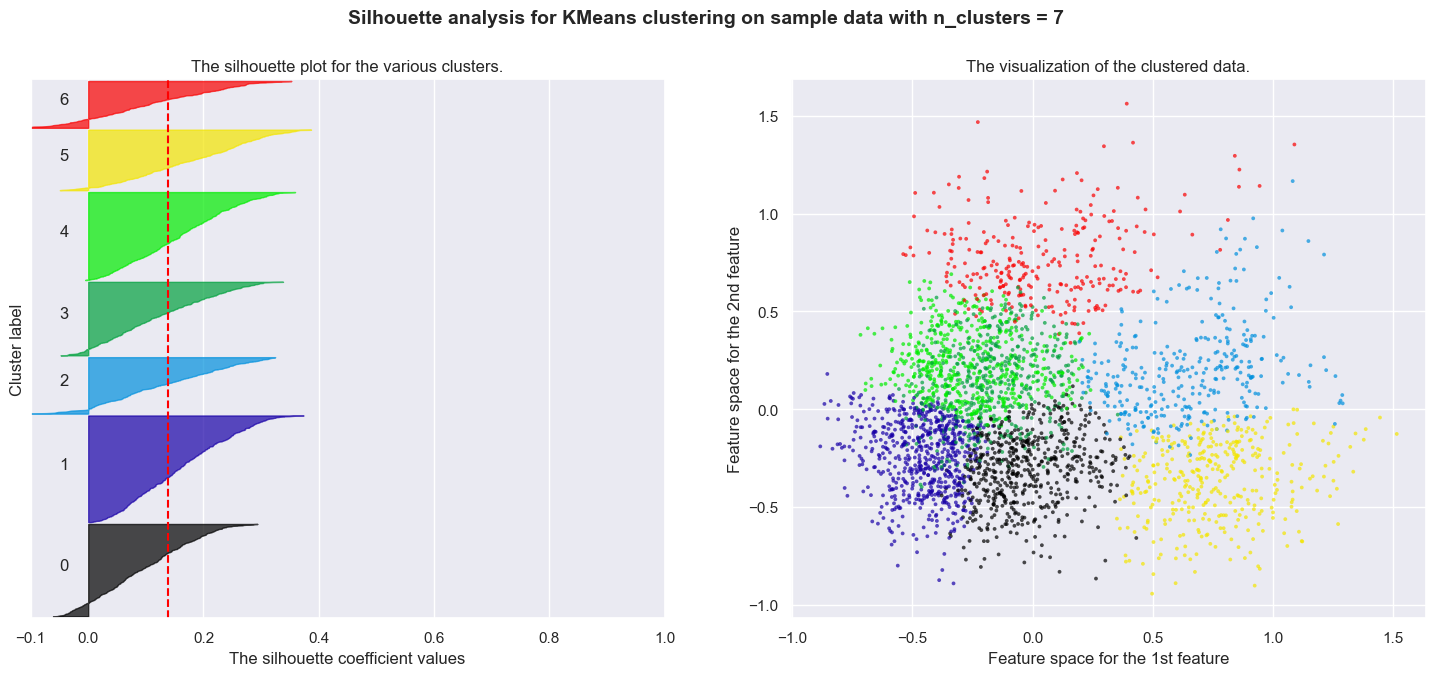

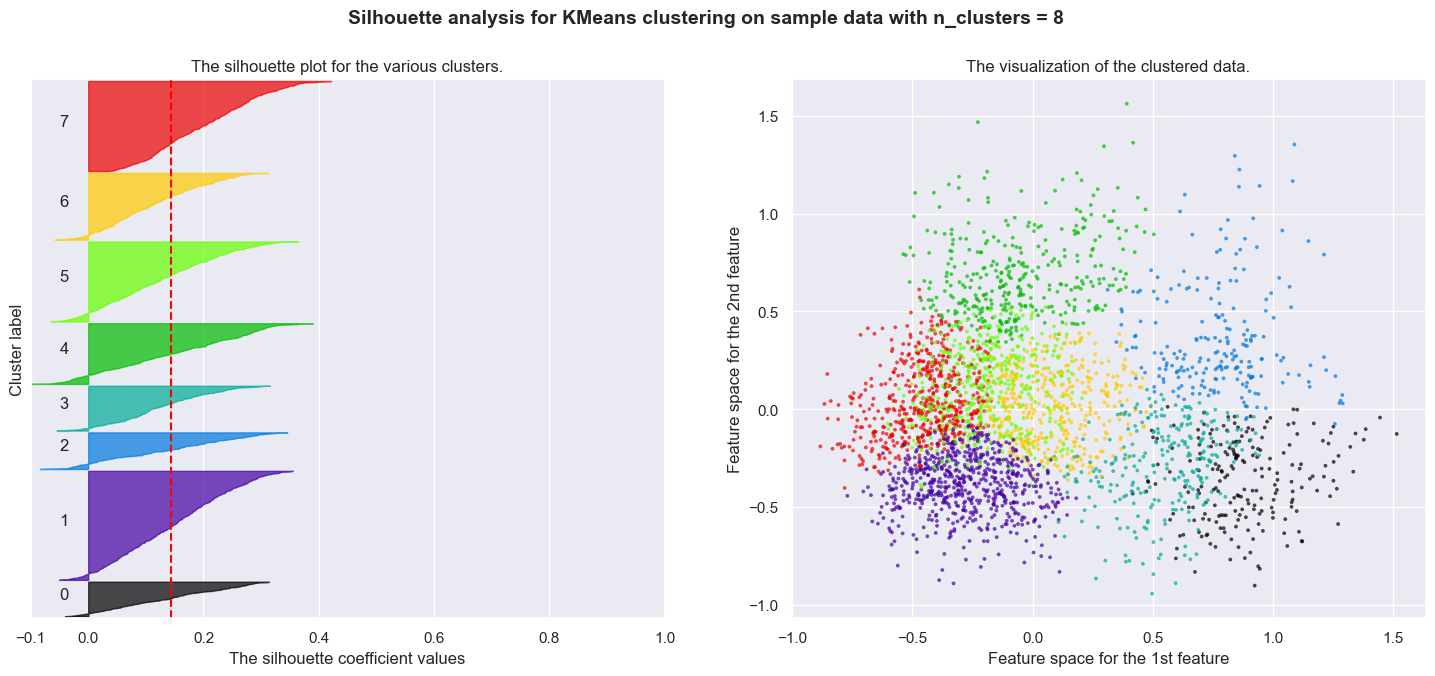

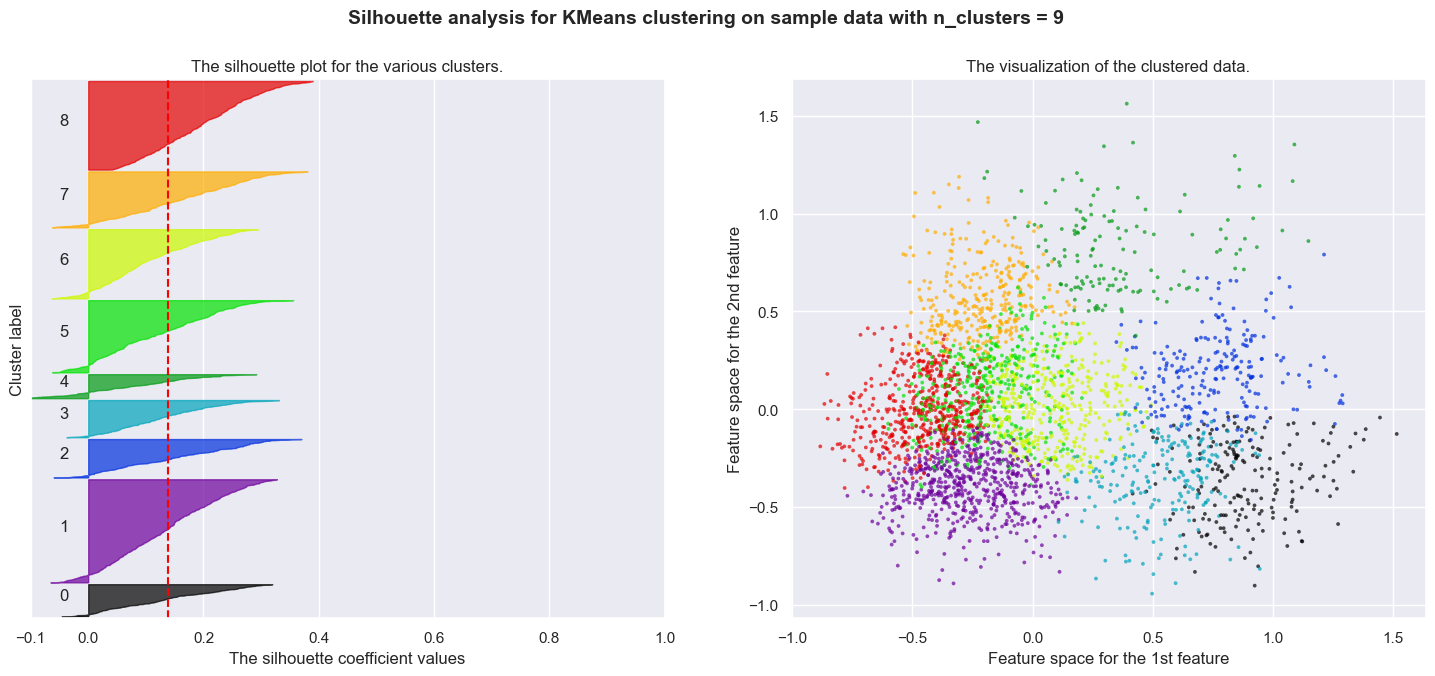

In [722]:

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_PCA[:, 0], X_PCA[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()